In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata
import geopandas as gpd
from pyproj import Proj, transform
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import glob
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds

In [2]:
list_files=glob.glob('/Users/hamidrezaomidvar/Desktop/LINDER/Colombo/fraction*')
df=pd.concat([pd.read_csv(f,index_col=0) for f in list_files])
df.columns=['lat','lon','Fr_Paved' ,'Fr_Grass','Fr_Water' ,'Fr_Bsoil','Fr_Bldgs']
df['Fr_EveTr']=0
df['Fr_DecTr']=0
df.head()

,lat,lon,Fr_Paved,Fr_Grass,Fr_Water,Fr_Bsoil,Fr_Bldgs,Fr_EveTr,Fr_DecTr
0,6.899419,79.811364,0.0,0.0,1.0,0.0,0.0,0,0
1,6.896995,79.811364,0.0,0.0,1.0,0.0,0.0,0,0
2,6.894570,79.811364,0.0,0.0,1.0,0.0,0.0,0,0
3,6.892146,79.811364,0.0,0.0,1.0,0.0,0.0,0,0
4,6.889721,79.811364,0.0,0.0,1.0,0.0,0.0,0,0


In [8]:
def toapp(row,to_inspect):
    ct=0
    if row[to_inspect]<0:
        all_cat=['Fr_Paved' ,'Fr_Grass','Fr_Water' ,'Fr_Bsoil','Fr_Bldgs']
        for i in [x for x in all_cat if x!=to_inspect]:
            if row[i]!=0:
                ct+=1
        for i in [x for x in all_cat if x!=to_inspect]:
            if row[i]!=0:
                row[i]=row[i]-row[to_inspect]/ct
        row[to_inspect]=0
    
    return row
for i in ['Fr_Paved' ,'Fr_Grass','Fr_Water' ,'Fr_Bsoil','Fr_Bldgs']:
    df=df.apply(lambda x:toapp(x,i),axis=1)

In [3]:
df.mean()[2:]

Fr_Paved    0.038071
Fr_Grass    0.116095
Fr_Water    0.331340
Fr_Bsoil    0.020366
Fr_Bldgs    0.494128
Fr_EveTr    0.000000
Fr_DecTr    0.000000
dtype: float64

In [4]:
lat=df['lat']
lon=df['lon']

In [5]:
p2_text='''
+units=m +init=ESRI:102009 +proj=lcc +lat_1=30 +lat_2=60 +lat_0=6.92 +lon_0=79.86 
+x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +no_defs +towgs84=0,0,0
'''

p1 = Proj(init='epsg:32631')
p2 = Proj(p2_text)
x1, y1 = p1(list(lon),list(lat))
x2, y2 = transform(p1,p2,x1,y1)

In [6]:
x_file='wrfinput_d03.suews'
ds_base = xr.open_dataset(x_file)
wrf_LAT=ds_base.XLAT.values[0,:,:]
wrf_LON=ds_base.XLONG.values[0,:,:]


wrf_X,wrf_Y=p2(wrf_LON,wrf_LAT)

In [7]:
def pc_plot(grid_x, grid_y,new_Z,name):
    plt.figure(figsize=(10,10))
    plt.pcolor(grid_x, grid_y,new_Z)
    plt.colorbar()
    plt.title(name)
    plt.ylabel('y')
    plt.xlabel('x')
    plt.savefig('fig/'+name+'.png', dpi=300, bbox_inches='tight', pad_inches=0.01)

In [8]:
def regrid_lower(name,df,wrf_X,wrf_Y,x2,y2):
    new_a=np.full_like(wrf_X,fill_value=0)
    count_a=np.full_like(wrf_X,fill_value=0)
    for x,y,val in zip(x2,y2,df[name]):

        for id_x,i in enumerate(wrf_X[0,:-1]):
            if x>=i and x<=wrf_X[0,id_x+1]:
                id_x_wrf=id_x
                i_wrf=i

        for id_y,j in enumerate(wrf_Y[:-1,0]):
            if y>=j and y<=wrf_Y[id_y+1,0]:
                id_y_wrf=id_y
                j_wrf=j

        new_a[id_y_wrf,id_x_wrf]+=val
        count_a[id_y_wrf,id_x_wrf]+=1
    z=np.divide(new_a,count_a,where=~np.isnan(new_a))
    return z

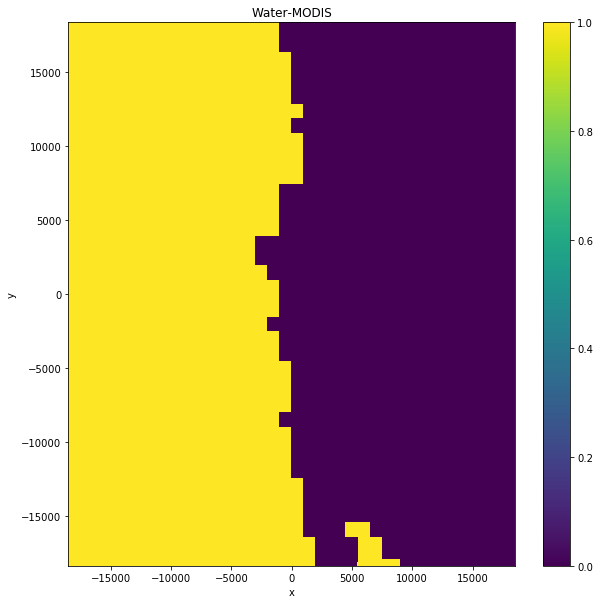

In [9]:
pc_plot(wrf_X, wrf_Y,ds_base['LANDUSEF'].values[0,16,:,:],'Water-MODIS')

In [10]:
names=['Fr_Paved' ,'Fr_Bldgs' ,'Fr_EveTr' ,'Fr_DecTr' ,'Fr_Grass' ,'Fr_Bsoil','Fr_Water']
new_all={}
for name in names:
    print(name)
    new_0=regrid_lower(name,df,wrf_X,wrf_Y,x2,y2)
    new_all[name]=new_0

Fr_Paved
Fr_Bldgs


/Users/hamidrezaomidvar/anaconda3/envs/main_env/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


Fr_EveTr
Fr_DecTr
Fr_Grass
Fr_Bsoil
Fr_Water


In [11]:
new_0=new_all['Fr_Paved']
cd=~np.isnan(new_0)
ds_base['LANDUSEF'].values[0,12,:,:][cd]=new_all['Fr_Paved'][cd]+new_all['Fr_Bldgs'][cd]
ds_base['LANDUSEF'].values[0,12,:,:][cd]=np.round(ds_base['LANDUSEF'].values[0,12,:,:][cd],2)

ds_base['LANDUSEF'].values[0,0,:,:][cd]=new_all['Fr_EveTr'][cd]/3
ds_base['LANDUSEF'].values[0,1,:,:][cd]=new_all['Fr_EveTr'][cd]/3
ds_base['LANDUSEF'].values[0,4,:,:][cd]=new_all['Fr_EveTr'][cd]/3

ds_base['LANDUSEF'].values[0,2,:,:][cd]=new_all['Fr_DecTr'][cd]/2
ds_base['LANDUSEF'].values[0,3,:,:][cd]=new_all['Fr_DecTr'][cd]/2

ds_base['LANDUSEF'].values[0,5,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,6,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,7,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,8,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,9,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,11,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,13,:,:][cd]=new_all['Fr_Grass'][cd]/7

ds_base['LANDUSEF'].values[0,15,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,17,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,18,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,19,:,:][cd]=new_all['Fr_Bsoil'][cd]/4


#ds_base['LANDUSEF'].values[0,10,:,:][cd]=new_all['Fr_Water'][cd]/2
ds_base['LANDUSEF'].values[0,16,:,:][cd]=new_all['Fr_Water'][cd]

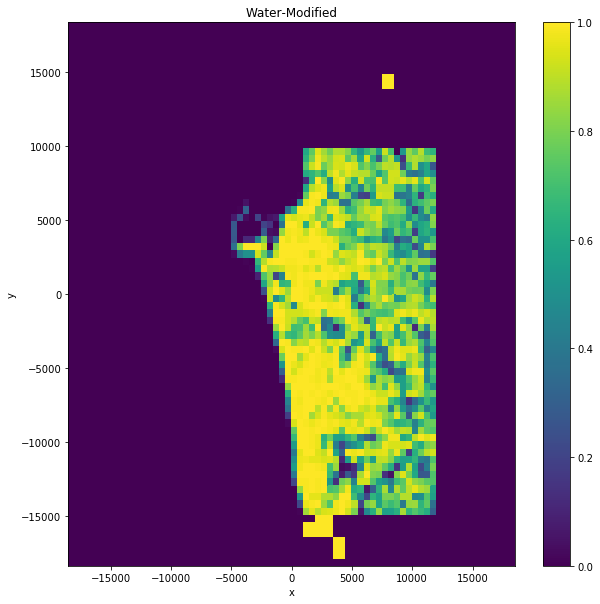

In [23]:
pc_plot(wrf_X, wrf_Y,ds_base['LANDUSEF'].values[0,12,:,:],'Water-Modified')

In [13]:
df_bldg=gpd.read_file('bldg_data/CMC_bldg_500mbuffer/CMC_bldg_500mbuffer.shp')
sub_df_bldg=df_bldg.filter(['FR_N_Floor','geometry'])

In [14]:
def change_to_floor(row):
    splits=row['FR_N_Floor'].split('G')
    #return splits
    if splits[1]=='':
        return 1*(7.5/2)
    else:
        return (7.5/2)*(1+int(splits[1].split('+')[1]))
    
sub_df_bldg['BldgH']=sub_df_bldg.apply(change_to_floor,axis=1)

In [15]:
df=sub_df_bldg #It is a shapefile dataframe with two columns of geometry and levels
dimns = 1000, 1000
dtype=rasterio.float64
transform_=rasterio.transform.from_bounds(*df.total_bounds, *dimns)

rasterize_rivernet = rasterize(
    [(shape, BldgH) for shape,BldgH in zip(df['geometry'],df['BldgH'])],
    out_shape=dimns,
    transform=transform_,
    fill=0,
    all_touched=True,
    dtype=dtype)

with rasterio.open(
    'rasterized.tif', 'w',
    driver='GTiff',
    dtype=dtype,
    count=1,
    width=dimns[0],
    height=dimns[1],
    transform=transform_
) as dst:
    dst.write(rasterize_rivernet, indexes=1)

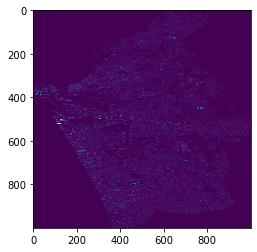

In [16]:
rst=rasterio.open('rasterized.tif',mode='r+')
plt.imshow(rst.read(1))

In [17]:
rst=rasterio.open('rasterized.tif',mode='r+')
data=rst.read(1)
Xs=[]
Ys=[]
Ds=[]
for i in range(rst.shape[0]):
    for j in range(rst.shape[0]):
        x,y=rst.transform*(i,j)
        Xs.append(x)
        Ys.append(y)
        Ds.append(data[i,j])

In [18]:
p3 = Proj(init='epsg:32644')
x3, y3 = transform(p3,p2,Xs,Ys)

In [19]:
def regrid_lower_2(Ds,wrf_X,wrf_Y,x2,y2):
    new_a=np.full_like(wrf_X,fill_value=0)
    count_a=np.full_like(wrf_X,fill_value=0)
    for x,y,val in zip(x2,y2,Ds):

        for id_x,i in enumerate(wrf_X[0,:-1]):
            if x>=i and x<=wrf_X[0,id_x+1]:
                id_x_wrf=id_x
                i_wrf=i

        for id_y,j in enumerate(wrf_Y[:-1,0]):
            if y>=j and y<=wrf_Y[id_y+1,0]:
                id_y_wrf=id_y
                j_wrf=j

        new_a[id_y_wrf,id_x_wrf]+=val
        count_a[id_y_wrf,id_x_wrf]+=1
    z=np.divide(new_a,count_a,where=~np.isnan(new_a))
    return z

In [20]:
names=['bldgH_SUEWS']
new_all={}
for name in names:
    print(name)
    new_0=regrid_lower_2(Ds,wrf_X,wrf_Y,x3,y3)
    new_all[name]=new_0
    
    ds_var=ds_base[name.upper()].values[0,:,:]
    ds_var[~np.isnan(new_0)]=new_0[~np.isnan(new_0)]
    zz=ds_base[name.upper()].values[0,:,:]
    zz[zz<0]=0
    zz[np.isnan(new_0) & (zz!=0)]=np.mean(zz[~np.isnan(new_0)])
    ds_base[name.upper()].values[0,:,:]=zz

bldgH_SUEWS


/Users/hamidrezaomidvar/anaconda3/envs/main_env/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


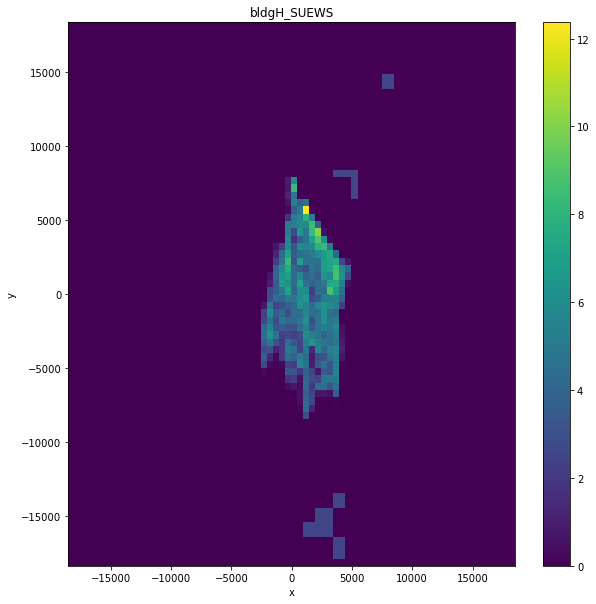

In [21]:
pc_plot(wrf_X, wrf_Y,ds_base[name.upper()].values[0,:,:],name)

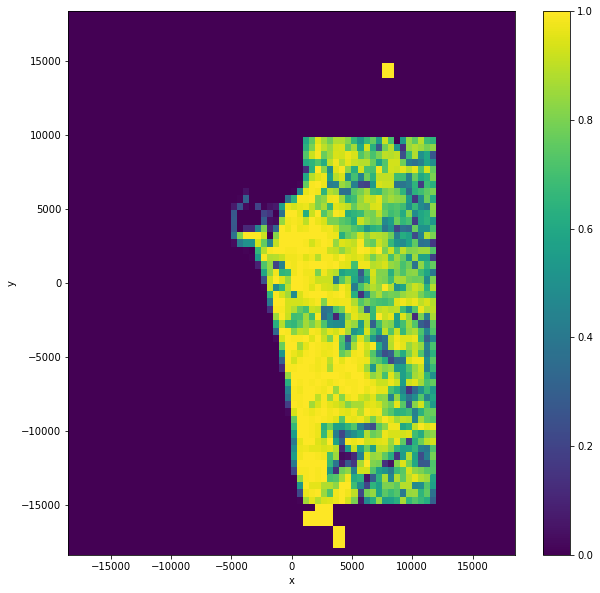

In [25]:
pc_plot(wrf_X, wrf_Y,ds_base['LANDUSEF'].values[0,12,:,:],'')

In [22]:
ds_merged = ds_base.update(ds_base)    

for var in ds_merged.data_vars.keys():
    if 'coordinates' in ds_merged[var].attrs:
        del ds_merged[var].attrs['coordinates']
        
file_out = x_file+'.new'

ds_merged.to_netcdf(file_out,
                    mode='w', format='NETCDF3_64BIT')
print('SUEWS input has been added to:' + file_out)

SUEWS input has been added to:wrfinput_d03.suews.new
